# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


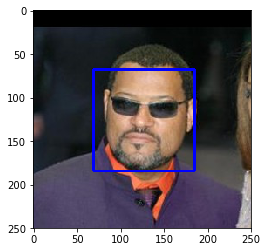

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- **99** human faces detected out of **100** images of human faces.
- **11** dog faces out of **100** were misclassified as being human faces

We can further define a *F1-score* as:

|       | precision | recall |
|-------|-----------|--------|
| human | 1         | 0.99   |
| dog   | 1         | 0.89   |

and so:
- recall[classifier] = 0.99 + 0.89 / 2 = 0.94
- precision[classifier] = 1

F1-score[classifier] = 2 \* (1 \* 0.94)/(1+0.94) = **0.969**

So we can conclute that it is quite good enough.

**Note**: Furthermore we might only use this function in a `else if` statement (after we have used a function to detect if there is a dog in the picture). By doing so (and if our `dog_detector` has a really good performance) we won't misclassify **11 %** of images of dog as being images of human faces (because if the image is really a dog then our `dog_detector` would have detected it in the `if` statement).

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# return the number of images in which we have detected a face
# img_paths: array of paths to images.
def faces_detector(img_paths):
    return sum([face_detector(img_path) for img_path in img_paths])

# compute the number of times the detector see a human face in all the images pass as a parameter
human_acc = faces_detector(human_files_short)

# compute the number of times the detector misclassify a dog face has been a human face.
dog_acc = faces_detector(dog_files_short)

# print statistics about the accuracy of faces_detector
print("We have detected {} human faces out of {} images of human faces".format(human_acc, len(human_files_short)))
print("We have misclassified {} dog faces as being {} human faces".format(dog_acc, len(dog_files_short)))

We have detected 99 human faces out of 100 images of human faces
We have misclassified 11 dog faces as being 100 human faces


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ A user interface should be:
- simple
- efficient

To meet those two specifications, we shouldn't impone our users to provide a clear view of a face (simplicity) while our system still need to achieve great performances (better than the other systems out there). Thus we can try to use a CNN to recognize a human face even if the face is not clearly distinguishable.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

## Optional Part ##
In this part I created a dataset by merging 3600 images from *lfw*, *caltech256* and *dogImages*.
The final dataset has thus 10800 images and 3 classes. I will further use this dataset to train
a ResNet50 NeuralNetwork to classify my 3 classes.

The hard part was to found a dataset providing only objects or landscapes and not people/faces. after
a bit of research I find caltech256 dataset quite relevant because it only contains objects. I erased the
**dog**, **face** folders and some other pictures (where we can find faces) from the caltech256 dataset

Finally after a bit of trimming, I created a function to construct a new dataset with 3 classes. To create my classes
I supposed that if my image comes from:
- caltech256 then it is an object with class 2
- lfw then it is obviously a face with class 1
- dogImages then it is obviously a dog with class 0

**Note**:
- I could have put all non faces objects into one 1 class and have 2 classes: **face** and **non face**
- I could have used another dataset for faces instead of **lfw**, so my CNN will be able to distinguish **non clearly visible faces**
- I could have augment the data. Thus if the head of a people is slightly titlt to the left (or right), the DNN will still recognize it as a face.
- ...

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

import random
random.seed(8675309)

# create train, valid, test dataset with images of:
# - human faces from lfw
# - dog from dogImages
# - objects from caltech256

# shuffle dog datasets before slicing it
random.shuffle(train_files)
random.shuffle(valid_files)
random.shuffle(test_files)

# fnf = face_non_face dataset;
# slice and append dog to fnf dataset
fnf_train = train_files[:2880] 
fnf_valid = valid_files[:360]
fnf_test = test_files[:360]

# function that splits a dataset into training, validation and test sets
# tvt = Train, Valid, Test
# array: dataset to split
# ratio_valid: ratio of data used to create the validation set
# ratio_test: ratio of data used to create the testing set
def split_tvt(array, ratio_valid=0.1, ratio_test=0.1):
    size = len(array)
    if (ratio_valid >= 1 or ratio_test >= 1 or
    ratio_valid <= 0 or ratio_test <= 0 or
    ratio_valid + ratio_test > 0.5):
        raise ValueError("ratio_valid + ratio_test should be 0.5 max\n \\
                         ratio_valid + ratio_test = %f here" % (ratio_valid+ratio_test))
    array = np.array(array)
    
    r_train = int( (1-ratio_valid-ratio_test) * size)
    r_valid = int( (1 - ratio_test) * size)
    r_test = int(size)
    
    train, valid, test, _ = np.split(array, [r_train, r_valid, r_test])
    return train, valid, test

# load images from human faces, shuffle it and slice it to get 3600 paths to the images
faces = glob("lfw/*/*")
random.shuffle(faces)
human_faces = faces[:3600]

# load objects (without human faces), shuffle it and slice it to get 3600 paths to the images
objects = glob("caltech256/*/*")
random.shuffle(objects)
simple_objects = objects[:3600]

# split faces and objects datasets into train, valid, test set using split_tvt
faces_train, faces_valid, faces_test = split_tvt(human_faces)
objects_train, objects_valid, objects_test = split_tvt(simple_objects)

# concatenate dogs, faces and objects into one big dataset called fnf_{type} (fnf = face_non_face)
# type is {train, valid, test}
fnf_train = np.concatenate([fnf_train, faces_train, objects_train])
fnf_valid = np.concatenate([fnf_valid, faces_valid, objects_valid])
fnf_test = np.concatenate([fnf_test, faces_test, objects_test])

# shuffle the latter dataset
random.shuffle(fnf_train)
random.shuffle(fnf_valid)
random.shuffle(fnf_test)

# function to associate 1 if image is a face, 2 if it's a dog and 0 otherwise
# In other words, function to create target classes for train, valid and test sets
def targets(*args):
    d = {}
    c = 0
    
    # create same number of target datasets as the number of input datasets
    targets = [0]*len(args)
    
    for s, t in zip(args, targets):
        # if image is in lfw folder then it's a face and t (target class) is 1
        # if image is in caltech256 folder then it's an object and t is 2
        # else, image is a dog (image comes from dogImages folder) an thus the target class is 0
        t = 1 if s[0].startswith("lfw\\") else 2 if s[0].startswith("caltech256\\") else 0
    
        for i in range(1, len(s)):
            value = 1 if s[i].startswith("lfw\\") else 2 if s[i].startswith("caltech256\\") else 0
            
            # add the class to the target dataset `t` associated with the input dataset `s`
            t = np.vstack((t, value))
        
        # convert class scalar into one-hot encoding
        # example: np_utils.to_categorical(1, 3)
        # returns: [0. 1. 0.]
        t = np_utils.to_categorical(t, 3)
        
        # add each target dataset to the `d` dictionary.
        # the first target dataset can be reach with the key: 0
        # the second with the key: 1
        # and so on
        d[c] = t
        c += 1
    
    # return train, valid, test target datasets
    return d[0], d[1], d[2]

# targets for train, valid, test sets (1 if human face, 0 otherwise)
fnf_train_targets, fnf_valid_targets, fnf_set_targets = targets(fnf_train, fnf_valid, fnf_test)

# print statistics about the dataset
print('There are %s total images.\n'
      % (len(np.hstack([fnf_train, fnf_valid, fnf_test]))))
print('There are %d training images. %d dogs, %d faces, %d objects'
      % (len(fnf_train), len(train_files[:2880] ), len(faces_train), len(objects_train)) )
print('There are %d validation images. %d dogs, %d faces, %d objects' 
      % (len(fnf_valid), len(valid_files[:360]), len(faces_valid), len(objects_valid)) )
print('There are %d test images. %d dogs, %d faces, %d objects'
      % (len(fnf_test), len(test_files[:360]), len(faces_test), len(objects_test)) )

There are 10800 total images.

There are 8640 training images. 2880 dogs, 2880 faces, 2880 objects
There are 1080 validation images. 360 dogs, 360 faces, 360 objects
There are 1080 test images. 360 dogs, 360 faces, 360 objects


Here I've just copied the function from **Step 2. Detect Dogs** to preprocess the data before using Keras

In [7]:
# Same code as part 2
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
fnf_train_tensors = paths_to_tensor(fnf_train).astype('float32')/255
fnf_valid_tensors = paths_to_tensor(fnf_valid).astype('float32')/255
fnf_test_tensors = paths_to_tensor(fnf_test).astype('float32')/255

100%|█████████████████████████████████████████████████████████████████████████████| 1080/1080 [00:06<00:00, 163.85it/s]


## Option Part : Training DNN for face detection
Then I used my newly created dataset to train a **RestNet50**
To do so, I used the pretrained (on ImageNet) RestNet50 implementation from Keras library.
I then add a `GlobalAveragePooling2D` and a `softmax` with **3 classes** to transform the output of my network into normalized probabilities. Finally I trained it using `rmsprop`optimizer.

**Note**: I added `from keras_tqdm import TQDMNotebookCallback` to be able to see a progressbar as I had encountered several issues while I was training my neural network (see related post on [Udacity forum](https://discussions.udacity.com/t/jupyter-notebook-freeze-while-training-solution/247335 "Freeze while training")).

**Note to myself**:
Don't execute the next Cell as I've already trained my network and I've already saved my best weights.

In [8]:
from keras import applications
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

model = applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze all the layer (even if we have enough data)
for layer in model.layers:
    layer.trainable = False

x = model.output
x = GlobalAveragePooling2D(input_shape=fnf_train_tensors.shape[1:])(x)
predictions = Dense(3, activation='softmax')(x)

# creating the final model
faces_model = Model(input=model.input, output=predictions)

# compile the model
faces_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Uncomment lines below to train it yourself (already trained and saved)
#checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.restnet50_faces.hdf5', 
#                               verbose=1, save_best_only=True)

#faces_model.fit(fnf_train_tensors, fnf_train_targets, 
#          validation_data=(fnf_valid_tensors, fnf_valid_targets),
#          epochs=20, batch_size=20, callbacks=[checkpointer, TQDMNotebookCallback()], verbose=0)

C:\Anaconda3\envs\aind-dog\lib\site-packages\ipykernel\__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


## Optional Part : End
Here I defined a function to load a image and to predict its class:
+ 1: human face
+ 2: object
+ 3: dog

I then created a function to predict if we can see a distinguishable face in the image using **restnet50**.
I finally test the performance (accuracy) of my `faces_detector` function on 100 unseen data from dogs, objects and faces.

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

# load pretrained weights for the restnet50 neural network
faces_model.load_weights('saved_models/weights.best.restnet50_faces.hdf5')

# compile the model
faces_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# return the most probable class to which belong the input image
# img_path: path to the input image
def ResNet50_predict_face(img_path):
    img = path_to_tensor(img_path).astype('float32')/255
    return np.argmax(faces_model.predict(img))

# return True if the function detects a face in the input image
# img_path: path to the input image
def face_detectorv2(img_path):
    prediction = ResNet50_predict_face(img_path)
    return prediction == 1

object_files_short = objects[3600:4000] # 400 objects unseen during training and validation
human_files_short = faces[3600:4000] # 400 human faces unseen during training and validation
dog_files_short = test_files[:400] # 400 dog faces unseen during training and validation

# return the number of images where we detected a face.
# img_paths: array of path to the input images
def faces_detectorv2(img_paths):
    return sum([face_detectorv2(img_path) for img_path in img_paths])

object_acc = faces_detectorv2(object_files_short) # number of faces detected in images that represent objects
human_acc = faces_detectorv2(human_files_short) # number of faces detected in images that represent human faces
dog_acc = faces_detectorv2(dog_files_short) # number of faces detected in images that represent dogs

# print statistics about the datas
print("We have detected {} human face(s) out of {} image(s) of human faces".format(human_acc, len(human_files_short)))
print("We have detected {} human face(s) out of {} image(s) of dogs".format(dog_acc, len(dog_files_short)))
print("We have detected {} human face(s) out of {} image(s) of objects".format(dog_acc, len(object_files_short)))

We have detected 400 human face(s) out of 400 image(s) of human faces
We have detected 0 human face(s) out of 400 image(s) of dogs
We have detected 0 human face(s) out of 400 image(s) of objects


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [10]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- **100** dog faces detected out of **100** images of dog faces.
- **1** human face out of **100** were misclassified as being a dog face

We can further define a *F1-score* as:

|       | precision | recall |
|-------|-----------|--------|
| dog   | 1         | 1      |
| human | 1         | 0.99   |

and so:
- recall[classifier] = 0.99 + 1 / 2 = 0.995
- precision[classifier] = 1

F1-score[classifier] = 2 \* (1 \* 0.995)/(1+0.995) = **0.997**

We can conclude that our detector is quite strong (and we should use it before using `face_detector`) as our `face_detector` miscalssify **11** images out of 100 (and this detector misclassify **1** image out of 100). By doing so we will therefore misclassify only **1** image out of 100. Indeed if we write:

```
if dog_detector():
    print("dog with accuracy of 1")
    print("misclassified human as dog: 1 % chance")
 else if face_detector():
    print("face with accuracy of 0.99")
    print("misclassified dog as human: 11 % chance")
 else
    raise ValueError()
```

**then**, if it is a:
- **dog**, we enter the `if` and we classify correctly: 100 % chance (well maybe not 100 % but close)
- **human**, two choices:
   - it is detected as being a dog and misclassified it with 1 % chance
   - it isn't detected as being a dog and we go to the `else if` and:
        - we classify it as being a human with 99 % chance
        - if we don't detect a human face (1 % chance) we go to the `else` and raise an error: 1 % chance

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# return the number of images that contain a dog
def dogs_detector(img_paths):
    return sum([dog_detector(img_path) for img_path in img_paths])

# number of human faces detected in images that represent dogs (ideally we want this number to be 0)
human_accv2 = dogs_detector(human_files_short)

# number of human faces detected in images that represent human faces
# (ideally we want this number to have the same size as the input array)
dog_accv2 = dogs_detector(dog_files_short)

# print statistics about the datas
print("We have detected {} dog faces out of {} images of dogs".format(dog_accv2, len(dog_files_short)))
print("We have misclassified {} human face(s) as being dog face(s) out of {} dog faces".format(human_accv2, len(human_files_short)))

We have detected 390 dog faces out of 400 images of dogs
We have misclassified 5 human face(s) as being dog face(s) out of 400 dog faces


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:11<00:00, 73.95it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 
I created a simple CNN for this task. The idea behind the architecture of my CNN is that I chose to:
- decrease the size of each filter at each Convolutional layer because according to state-of-the-art papers having small filters is better for high performances.
- I added Dropout to avoid overfitting at each step. And I incremented the value of the percentage of dropout because the first convolutional layers have fewer parameters to update and allow us to recognize shape and texture while the last convolutional layers allow to distinguish complex geometric shape and hence need a higher dropout to avoid overfitting.
- I add l2 regularizer to avoid overfitting
- I chose a GAP layer to decrease the number of parameters to update and hence also avoid overfitting.
- I choose max-pooling layers of size 2 to slowly decrease the high and width and hence grasp both general texture and shape (first layers) and precise complex shapes (last layers)
- I choose to decrease the width and height of the activation map (with max-pooling) while I'm increasing the number of filters. Hence I have a higher depth, and so a higher number of activation maps.

**Note**: I was able to achieve 4.25 % accuracy within 1 epoch with a similar Network (without a GAP layer and with fewer layers) but after retraining the Network several times I could not achieve such an accuracy again (even with the exact same architecture).

In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import regularizers

# set input shape to (224, 224, 3): train_tensors is shape (1, 224, 224, 3)
input_shape = train_tensors.shape[1:]

# set number of classes to the number of different dog breeds.
nb_classes = len(dog_names)

# initialize a sequential model
model = Sequential()

# add Convolutional layer with 32 filters, having the same shape as our input data (image of size 224x224 with 3 channels)
# kernel_size is the size of the filter. Here it is a (3,3) filter
# relu is the activation function. It allow us to decrease overfitting and he is the most wiedly used activation function
# in state of the art paper
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))

# add Dropout ratio of 0.1. That means that 10 % of the neurons will be 'kill' on purpose and we will only
# train 0.9 % of the neurons. It allows the neurons to be more self-indepedant from the others neurons and hence
# allow to decrease overfitting.
model.add(Dropout(0.1))

# add max-pooling layer of size 2. That means we will select only the `pixel` that are the highest value during
# forward propagation
model.add(MaxPooling2D(pool_size=2))

# I won't detail the other layers are the are the same.
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=1, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=1, padding='same', activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=2))

# add Gloval Average Pooling (http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)
# it allows to decrease overfitting while obtaining same accuracy as Fully Connected Neural Network. Indeed with GAP
# we have less parameters to update!
model.add(GlobalAveragePooling2D(input_shape=input_shape))

# add nb_classes = 133 neurons at the end and turn each number into normalize probabilities using softmax activation function
# add L2 regularizer to prevent overfitting
model.add(Dense(nb_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.1)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
dropout_8 (Dropout)          (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
dropout_9 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 128)       32896     
__________

### Compile the Model

In [20]:
from keras import optimizers

# initialize rmsprop optimizer with learning rate=0.001 and learning decay=0.1
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.1)

# compile the model
model.compile(optimizer=rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [52]:
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 20

### Do NOT modify the code below this line.
# save the best weights during training.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
# train the model
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer, TQDMNotebookCallback()], verbose=0)

Epoch 00000: val_loss improved from inf to 5.89484, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00001: val_loss improved from 5.89484 to 5.75699, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00002: val_loss improved from 5.75699 to 5.68318, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00003: val_loss improved from 5.68318 to 5.63395, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00004: val_loss improved from 5.63395 to 5.59760, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00005: val_loss improved from 5.59760 to 5.56904, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00006: val_loss improved from 5.56904 to 5.54572, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00007: val_loss improved from 5.54572 to 5.52608, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00008: val_loss improved from 5.52608 to 5.50920, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00009: val_loss improved from 5.50920 to 5.49447, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00010: val_loss improved from 5.49447 to 5.48142, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00011: val_loss improved from 5.48142 to 5.46973, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00012: val_loss improved from 5.46973 to 5.45918, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00013: val_loss improved from 5.45918 to 5.44958, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00014: val_loss improved from 5.44958 to 5.44077, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00015: val_loss improved from 5.44077 to 5.43266, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00016: val_loss improved from 5.43266 to 5.42515, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00017: val_loss improved from 5.42515 to 5.41815, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00018: val_loss improved from 5.41815 to 5.41162, saving model to saved_models/weights.best.from_scratch.hdf5


Epoch 00019: val_loss improved from 5.41162 to 5.40550, saving model to saved_models/weights.best.from_scratch.hdf5


### Load the Model with the Best Validation Loss

In [53]:
# load the weights
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [54]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.0766%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [21]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [22]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax', kernel_regularizer=regularizers.l2(0.1)))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [24]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [25]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=200, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 15.91215, saving model to saved_models/weights.best.VGG16.hdf5
2s - loss: 23.6230 - acc: 0.0771 - val_loss: 15.9122 - val_acc: 0.1341
Epoch 2/20
Epoch 00001: val_loss improved from 15.91215 to 8.49369, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 11.4135 - acc: 0.2982 - val_loss: 8.4937 - val_acc: 0.3808
Epoch 3/20
Epoch 00002: val_loss improved from 8.49369 to 5.58052, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 6.3596 - acc: 0.5501 - val_loss: 5.5805 - val_acc: 0.5162
Epoch 4/20
Epoch 00003: val_loss improved from 5.58052 to 3.96539, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 4.1077 - acc: 0.6781 - val_loss: 3.9654 - val_acc: 0.5832
Epoch 5/20
Epoch 00004: val_loss improved from 3.96539 to 3.12504, saving model to saved_models/weights.best.VGG16.hdf5
1s - loss: 2.8901 - acc: 0.7404 - val_loss: 3.1250 - val_acc: 0.5940
Epoch 6

### Load the Model with the Best Validation Loss

In [26]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [27]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 68.8995%


### Predict Dog Breed with the Model

In [31]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [16]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_RESTNET = bottleneck_features['train']
valid_RESTNET = bottleneck_features['valid']
test_RESTNET = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I used the RestNet model. As the Restnet model was trained on a similar dataset and as my dataset is quite big enough (8000 images of dogs), I can load the restnet_model, freeze the weights of the restnet50 model and add a GAP layer with a softmax activation function to retrieve the most probable breed associated with each image.

During training, I will thus only update the weights of the final layers I added.

Using a GAP instead of a Fully Connected Layer (Dense layer) at the end, allow to reduce the number of weights to update during trainig and thus prevent overfitting. It decreases the complexity of the model while achieving great performances.

All the architecture choice is described in the inline comments below:

In [20]:
### TODO: Define your architecture.
RESTNET_model = Sequential()

# add GAP layer at the end
RESTNET_model.add(GlobalAveragePooling2D(input_shape=train_RESTNET.shape[1:]))

# add dropout to prevent overfitting
RESTNET_model.add(Dropout(0.3))

# add 133 neurons at the end (on for each classes) with a softmax activation function to turn
# the number into normalized probabilities
RESTNET_model.add(Dense(133, activation='softmax'))

RESTNET_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [21]:
### TODO: Compile the model.
RESTNET_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [22]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.restnet.hdf5', 
                               verbose=1, save_best_only=True)

RESTNET_model.fit(train_RESTNET, train_targets, 
          validation_data=(valid_RESTNET, valid_targets),
          epochs=20, batch_size=200, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 1.60056, saving model to saved_models/weights.best.restnet.hdf5
1s - loss: 3.0502 - acc: 0.3413 - val_loss: 1.6006 - val_acc: 0.6216
Epoch 2/20
Epoch 00001: val_loss improved from 1.60056 to 1.01468, saving model to saved_models/weights.best.restnet.hdf5
0s - loss: 1.1747 - acc: 0.7087 - val_loss: 1.0147 - val_acc: 0.7269
Epoch 3/20
Epoch 00002: val_loss improved from 1.01468 to 0.82772, saving model to saved_models/weights.best.restnet.hdf5
0s - loss: 0.7092 - acc: 0.8193 - val_loss: 0.8277 - val_acc: 0.7557
Epoch 4/20
Epoch 00003: val_loss improved from 0.82772 to 0.69249, saving model to saved_models/weights.best.restnet.hdf5
0s - loss: 0.4983 - acc: 0.8698 - val_loss: 0.6925 - val_acc: 0.8000
Epoch 5/20
Epoch 00004: val_loss improved from 0.69249 to 0.62231, saving model to saved_models/weights.best.restnet.hdf5
0s - loss: 0.3650 - acc: 0.9070 - val_loss: 0.6223 - val_acc: 0.8144
Ep

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [23]:
### TODO: Load the model weights with the best validation loss.
RESTNET_model.load_weights('saved_models/weights.best.restnet.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [24]:
### TODO: Calculate classification accuracy on the test dataset.
RESTNET_predictions = [np.argmax(RESTNET_model.predict(np.expand_dims(feature, axis=0))) for feature in test_RESTNET]

# report test accuracy
test_accuracy = 100*np.sum(np.array(RESTNET_predictions)==np.argmax(test_targets, axis=1))/len(RESTNET_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.6555%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [28]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def RESTNET_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = RESTNET_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [29]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
def display_img(img_path):
    # load color (BGR) image
    img = cv2.imread(img_path)
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    return cv_rgb

# function that takes as input a path to an image
# the image should either contains a distinguishable human face or a dog.
# if the image is a human face then it returns the dog breed that looks
# the most like the input image. If the image is a dog, the function returns
# the dog breeds it thinks the dog belongs to
def you_look_like(img_path):
    # header contains "Hello, human!" if it's a human
    header = ""
    
    # string containing dog breed
    dog_name = ""
    
    # string containing introducing sentence (either "This is a dog" or "You look like a...")
    introducing_sentence = ""
    
    if dog_detector(img_path): # if dog detected
        introducing_sentence = "This dog is a "
    elif face_detector(img_path) or face_detectorv2(img_path): # if faces detected
        header = "Hello, human!\n"
        introducing_sentence = "You look like a... "
    else: # if nothing detected return error with the path to the image that raised the error
        raise ValueError('Dog or human faces non detected in file: ', img_path)
    # retrieve the dog name associated with the image using a Deep Neural Network
    dog_name = RESTNET_predict_breed(img_path)
    # return header text, input image, text introducing the guessed dog breed
    return header, display_img(img_path), introducing_sentence + dog_name.replace('_', ' ')

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
The output is quite coherent. Obviously, it doesn't recognize all the dogs because some of them pretty look alike as mentioned in **part 3**. Nonetheless, I don't think I'll be as accurate as this Neural Network for recognizing some of the dogs that look alike so I'm pretty satisfied with this model.

Although we can clearly see a similarity between human pictures and dog pictures. For example:
- the human with the beard looks like a dog with a kind of similar fur
- the grandma looks like a Silky Terrier (which is a dog that looks old)
- I look like a Xoloitzcuintli, well... Maybe not!

Finally, there are tons of ways I could improve my algorithm:
- Train on more images and in particular, try to merge the **dogImages** dataset with the [Stanford Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/)
- augment the images. For example, I noticed that If my head is tilt to the left or right, the NN might not recognize me. Hence we can improve the face detection by augmenting the dataset and also by using another dataset beside *lfw* so the algorithm will be able to detect non-clearly visible faces.
- Be able to distinguish several people in a picture and find the most resembling dog for each of the people.
- Use Deconvolution to depict which _neurons_ fire when the Neural Network see a human face to understand why such a specific dog breed was outputted by the Neural Network
- display a random picture of the dog you look like next to your face along with the name of the dog (to avoid making research on the internet afterward)
- output the top-n dogs to which your dog or human picture  look like along with the probabilities
- ...

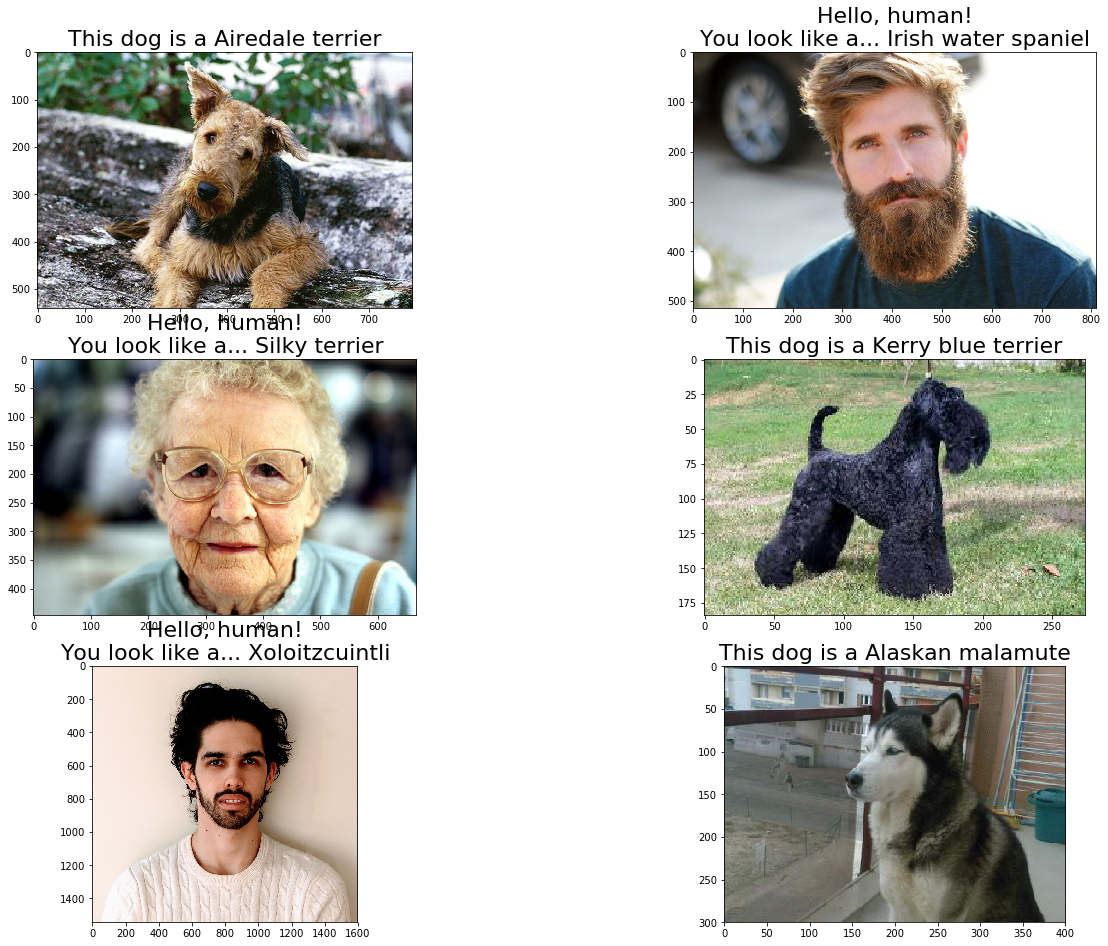

In [32]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
from math import ceil

# function that attempt to recognize a dog breed. It takes as input
# a path to a folder containing the images we want to know the dog breeds.
# Note: if the image appears to be a human face, the function will return
# the dog breed that looks the most like the input image.
def img_recognizer(folder_path):
    # load the images from folder path
    imgs = glob(folder_path)
    # define size of ouput figure
    fig = plt.figure(figsize=(22, 16))
    
    # define number of rows to output: number of images / 2
    # where 2 is the number of columns
    nrows = ceil(len(imgs) / 2)
    
    # iterates through input image path
    for i, img in enumerate(imgs, 1):
        # retrive header text, input picture, text introducing the dog breed
        # using you_look_like function defined previously
        header, picture, text = you_look_like(img)
        
        # add the i-th subplots
        ax = fig.add_subplot(nrows, 2, i)
        if header: # if human
            # add "Hello human!" to the text variable
            text = header + text
        # plot the text
        ax.set_title(text, fontsize="22")
        # plot the image
        ax.imshow(picture)
    # plot the figure containing all the subplots
    plt.show()
        
# call to img_recognizer with path to all the image from the folder "test_images"
img_recognizer("test_images/*")